# Backtesting

Backtesting is a term used in modeling to refer to testing a predictive model on historical data. Backtesting involves moving backwards in time, step-by-step, in as many stages as are considered necessary. Therefore, it is a special type of cross-validation applied to previous time period(s).

**Backtesting with refit**

The model is trained each time before making predictions. With this configuration, the model uses all the information available so far. It is a variation of the standard cross-validation but, instead of making a random distribution of the observations, the training set increases sequentially, maintaining the temporal order of the data.

<p align="center"><img src="../img/diagram-backtesting-refit.png" style="width: 500px;"></p>

<p align="center"><img src="../img/backtesting_refit.gif" style="width: 600px;"></p>

**Backtesting with refit and fixed train size**

A technique similar to backtesting with refit but, in this case, the training set doesn't increase sequentially. This is also known as time series cross-validation or walk-forward validation.

<p align="center"><img src="../img/diagram-backtesting-refit-fixed-train-size.png" style="width: 500px;"></p>

<p align="center"><img src="../img/backtesting_refit_fixed_train_size.gif" style="width: 600px;"></p>


**Backtesting without refit**

After an initial train, the model is used sequentially without updating it and following the temporal order of the data. This strategy has the advantage of being much faster since the model is trained only once. However, the model does not incorporate the latest information available, so it may lose predictive capacity over time.

<p align="center"><img src="../img/diagram-backtesting-no-refit.png" style="width: 500px;"></p>

<p align="center"><img src="../img/backtesting_no_refit.gif" style="width: 600px;"></p>

## Libraries

In [1]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

## Data

Train dates      : 1991-07-01 00:00:00 --- 2002-01-01 00:00:00  (n=127)
Validation dates : 2002-02-01 00:00:00 --- 2008-06-01 00:00:00  (n=77)


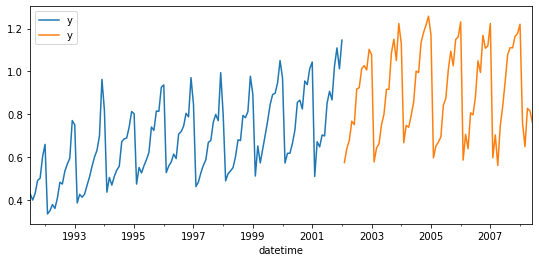

,y
datetime,
1991-07-01,0.429795
1991-08-01,0.400906
1991-09-01,0.432159
1991-10-01,0.492543


In [3]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
data = pd.read_csv(url, sep=',', header=0, names=['y', 'datetime'])

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y/%m/%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data[['y']]
data = data.sort_index()

# Train-validation dates
# ==============================================================================
end_train = '2002-01-01 23:59:00'

print(f"Train dates      : {data.index.min()} --- {data.loc[:end_train].index.max()}  (n={len(data.loc[:end_train])})")
print(f"Validation dates : {data.loc[end_train:].index.min()} --- {data.index.max()}  (n={len(data.loc[end_train:])})")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='validation')
ax.legend()
plt.show()

display(data.head(4))

## Backtest

In [11]:
# Backtest forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                  regressor = RandomForestRegressor(random_state=123),
                  lags      = 15 
             )

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data['y'],
                                    initial_train_size = len(data.loc[:end_train]),
                                    fixed_train_size   = False,
                                    steps      = 10,
                                    metric     = 'mean_squared_error',
                                    refit      = True,
                                    verbose    = True
                               )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 127
Number of observations used for backtesting: 77
    Number of folds: 8
    Number of steps per fold: 10
    Last fold only includes 7 observations.

Data partition in fold: 0
    Training:   1991-07-01 00:00:00 -- 2002-01-01 00:00:00
    Validation: 2002-02-01 00:00:00 -- 2002-11-01 00:00:00
Data partition in fold: 1
    Training:   1991-07-01 00:00:00 -- 2002-11-01 00:00:00
    Validation: 2002-12-01 00:00:00 -- 2003-09-01 00:00:00
Data partition in fold: 2
    Training:   1991-07-01 00:00:00 -- 2003-09-01 00:00:00
    Validation: 2003-10-01 00:00:00 -- 2004-07-01 00:00:00
Data partition in fold: 3
    Training:   1991-07-01 00:00:00 -- 2004-07-01 00:00:00
    Validation: 2004-08-01 00:00:00 -- 2005-05-01 00:00:00
Data partition in fold: 4
    Training:   1991-07-01 00:00:00 -- 2005-05-01 00:00:00
    Validation: 2005-06-01 00:00:00 -- 2006-03-01 00:00:00
Data pa

In [12]:
print(f"Backtest error: {metric}")

Backtest error: 0.00818535931502708


In [13]:
predictions_backtest.head(4)

,pred
2002-02-01,0.594506
2002-03-01,0.785886
2002-04-01,0.698925
2002-05-01,0.790560


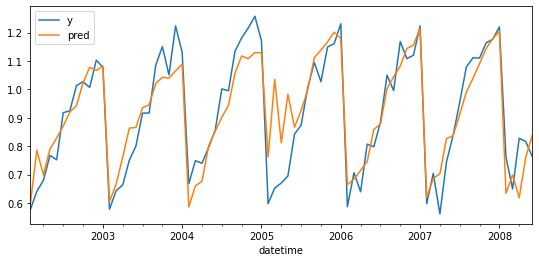

In [15]:
fig, ax = plt.subplots(figsize=(9, 4))
data.loc[end_train:, 'y'].plot(ax=ax)
predictions_backtest.plot(ax=ax)
ax.legend();

## Backtest with prediction intervals

In [16]:
# Backtest forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = Ridge(),
                lags      = 15 
             )

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data['y'],
                                    initial_train_size = len(data.loc[:end_train]),
                                    fixed_train_size   = False,
                                    steps      = 10,
                                    metric     = 'mean_squared_error',
                                    refit      = True,
                                    interval   = [5, 95],
                                    n_boot     = 500,
                                    verbose    = True
                               )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 127
Number of observations used for backtesting: 77
    Number of folds: 8
    Number of steps per fold: 10
    Last fold only includes 7 observations.

Data partition in fold: 0
    Training:   1991-07-01 00:00:00 -- 2002-01-01 00:00:00
    Validation: 2002-02-01 00:00:00 -- 2002-11-01 00:00:00
Data partition in fold: 1
    Training:   1991-07-01 00:00:00 -- 2002-11-01 00:00:00
    Validation: 2002-12-01 00:00:00 -- 2003-09-01 00:00:00
Data partition in fold: 2
    Training:   1991-07-01 00:00:00 -- 2003-09-01 00:00:00
    Validation: 2003-10-01 00:00:00 -- 2004-07-01 00:00:00
Data partition in fold: 3
    Training:   1991-07-01 00:00:00 -- 2004-07-01 00:00:00
    Validation: 2004-08-01 00:00:00 -- 2005-05-01 00:00:00
Data partition in fold: 4
    Training:   1991-07-01 00:00:00 -- 2005-05-01 00:00:00
    Validation: 2005-06-01 00:00:00 -- 2006-03-01 00:00:00
Data pa

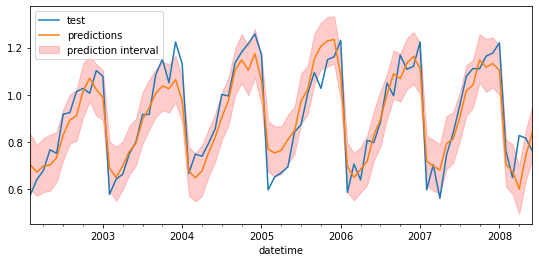

In [17]:
fig, ax=plt.subplots(figsize=(9, 4))
data.loc[end_train:, 'y'].plot(ax=ax, label='test')
predictions_backtest.iloc[:, 0].plot(ax=ax, label='predictions')
ax.fill_between(
    predictions_backtest.index,
    predictions_backtest.iloc[:, 1],
    predictions_backtest.iloc[:, 2],
    color = 'red',
    alpha = 0.2,
    label = 'prediction interval'
)
ax.legend();

## Predictions on training data

Predictions on training data can be obtained either by using the `backtesting_forecaster()` function or by accessing the `predict()` method of the regressor stored inside the forecaster object.

### Predict using backtesting_forecaster()

A trained forecaster is needed.

In [11]:
# Fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 15 
             )

forecaster.fit(y=data['y'])

Set arguments `initial_train_size = None` and `refit = False` to perform backtesting using the already trained forecaster. 

In [12]:
# Backtest train data
# ==============================================================================
metric, predictions_train = backtesting_forecaster(
                                   forecaster = forecaster,
                                   y          = data['y'],
                                   initial_train_size = None,
                                   steps      = 1,
                                   metric     = 'mean_squared_error',
                                   refit      = False,
                                   verbose    = False
                            )

print(f"Backtest training error: {metric}")

Backtest training error: 0.0005392479040738611


In [13]:
predictions_train.head(4)

,pred
1992-10-01,0.553611
1992-11-01,0.568324
1992-12-01,0.735167
1993-01-01,0.723217


The first 15 observations are not predicted since they are needed to create the lags used as predictors.

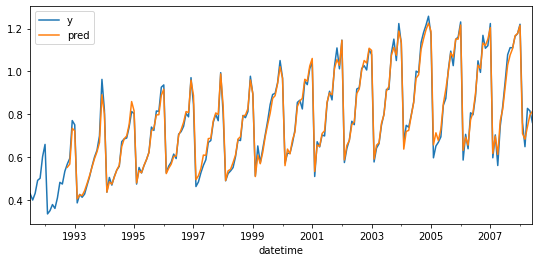

In [14]:
# Plot training predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data.plot(ax=ax)
predictions_train.plot(ax=ax)
ax.legend();

### Predict using the internal regressor

In [15]:
# Fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 15
             )

forecaster.fit(y=data['y'])

In [16]:
# Create training matrix
# ==============================================================================
X, y = forecaster.create_train_X_y(
               y = data['y'], 
               exog = None
       )

Using the internal regressor only allows predicting one step.

In [17]:
# Predict using the internal regressor
# ==============================================================================
forecaster.regressor.predict(X)[:4]

array([0.55361079, 0.56832448, 0.73516725, 0.72321715])

## Backtest with a custom metric

`backtesting_forecaster()` function allows a calleable metric.

In [18]:
def custom_metric(y_true, y_pred):
    '''
    Custom metric function
    '''
    metric = ((y_true - y_pred)/len(y_true)).mean()
    
    return metric

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data['y'],
                                    initial_train_size = len(data.loc[:end_train]),
                                    fixed_train_size   = False,
                                    steps      = 10,
                                    metric     = custom_metric,
                                    refit      = True,
                                    verbose    = False
                               )

print(f"Backtest error custom metric: {metric}")

Backtest error custom metric: 0.00014742262249238132


## Backtest with exogenous variables

Train dates      : 1992-04-01 00:00:00 --- 2002-01-01 00:00:00  (n=118)
Validation dates : 2002-02-01 00:00:00 --- 2008-06-01 00:00:00  (n=77)


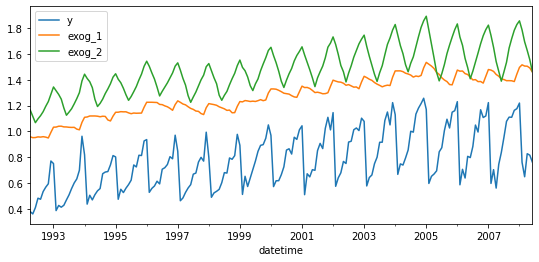

In [19]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv')
data = pd.read_csv(url, sep=',', header=0, names=['datetime', 'y', 'exog_1', 'exog_2'])

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y/%m/%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data.sort_index()

# Train-validation dates
# ==============================================================================
end_train = '2002-01-01 23:59:00'

print(f"Train dates      : {data.index.min()} --- {data.loc[:end_train].index.max()}  (n={len(data.loc[:end_train])})")
print(f"Validation dates : {data.loc[end_train:].index.min()} --- {data.index.max()}  (n={len(data.loc[end_train:])})")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data.plot(ax=ax);

In [20]:
# Backtest forecaster exogenous variables
# ==============================================================================
forecaster = ForecasterAutoreg(
                  regressor = RandomForestRegressor(random_state=123),
                  lags      = 15 
             )

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data['y'],
                                    exog       = data[['exog_1', 'exog_2']],
                                    initial_train_size = len(data.loc[:end_train]),
                                    fixed_train_size   = False,
                                    steps      = 10,
                                    metric     = 'mean_squared_error',
                                    refit      = True,
                                    verbose    = True
                               )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 118
Number of observations used for backtesting: 77
    Number of folds: 8
    Number of steps per fold: 10
    Last fold only includes 7 observations.

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 2002-01-01 00:00:00
    Validation: 2002-02-01 00:00:00 -- 2002-11-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2002-11-01 00:00:00
    Validation: 2002-12-01 00:00:00 -- 2003-09-01 00:00:00
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 2003-09-01 00:00:00
    Validation: 2003-10-01 00:00:00 -- 2004-07-01 00:00:00
Data partition in fold: 3
    Training:   1992-04-01 00:00:00 -- 2004-07-01 00:00:00
    Validation: 2004-08-01 00:00:00 -- 2005-05-01 00:00:00
Data partition in fold: 4
    Training:   1992-04-01 00:00:00 -- 2005-05-01 00:00:00
    Validation: 2005-06-01 00:00:00 -- 2006-03-01 00:00:00
Data pa

In [21]:
print(f"Backtest error with exogenous variables: {metric}")

Backtest error with exogenous variables: 0.007800037462113706


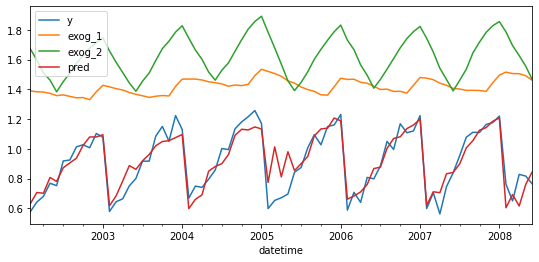

In [23]:
fig, ax = plt.subplots(figsize=(9, 4))
data.loc[end_train:].plot(ax=ax)
predictions_backtest.plot(ax=ax)
ax.legend();

In [23]:
%%html
<style>
.jupyter-wrapper .jp-CodeCell .jp-Cell-inputWrapper .jp-InputPrompt {display: none;}
</style>